In [ ]:
import pandas as pd
import torch
import json
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix, roc_curve, precision_recall_curve
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('/content/Ecare_3.json', 'r') as f:
    ecare_1 = [json.loads(line) for line in f]

# Define split sizes for a 75-25 split of the data
train_size = int(0.75 * len(ecare_1))
train_data = ecare_1[:train_size]
validation_data = ecare_1[train_size:]

class EcareDataset(Dataset):
    def __init__(self, ecare_data, tokenizer):
        self.ecare_data = ecare_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.ecare_data)

    def __getitem__(self, idx):
        data = self.ecare_data[idx]
        premise = data['premise']
        hypotheses = [data['hypothesis1'], data['hypothesis2']]
        label = data['label']

        encoded_input = self.tokenizer(premise, hypotheses, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        input_ids = encoded_input['input_ids'].squeeze(0)
        attention_mask = encoded_input['attention_mask'].squeeze(0)
        label = torch.tensor(label)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}

# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base')

ecare_dataset = EcareDataset(train_data, tokenizer)
dataloader = DataLoader(ecare_dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(3):
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

validation_dataset = EcareDataset(validation_data, tokenizer)
validation_dataloader = DataLoader(validation_dataset, batch_size=64)

model.eval()
y_true, y_pred, y_scores = [], [], []

def compute_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        y_scores_batch = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_scores.extend(y_scores_batch)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss: 0.6998515129089355
Epoch: 0, Loss: 0.7036404609680176
Epoch: 0, Loss: 0.7482597231864929
Epoch: 0, Loss: 0.6920239925384521
Epoch: 0, Loss: 0.7092602849006653
Epoch: 0, Loss: 0.7034724950790405
Epoch: 0, Loss: 0.7245509624481201
Epoch: 0, Loss: 0.7130870223045349
Epoch: 0, Loss: 0.7041749358177185
Epoch: 0, Loss: 0.6932309865951538
Epoch: 0, Loss: 0.6953769326210022
Epoch: 0, Loss: 0.6912693977355957
Epoch: 0, Loss: 0.7015673518180847
Epoch: 0, Loss: 0.6957395076751709
Epoch: 0, Loss: 0.690415620803833
Epoch: 0, Loss: 0.7132752537727356
Epoch: 0, Loss: 0.6924604177474976
Epoch: 0, Loss: 0.7173413038253784
Epoch: 0, Loss: 0.7321779727935791
Epoch: 0, Loss: 0.701056182384491
Epoch: 0, Loss: 0.7020735144615173
Epoch: 0, Loss: 0.6759060621261597
Epoch: 0, Loss: 0.6991520524024963
Epoch: 0, Loss: 0.6678950190544128
Epoch: 0, Loss: 0.7223773002624512
Epoch: 0, Loss: 0.7087171077728271
Epoch: 0, Loss: 0.6852413415908813
Epoch: 0, Loss: 0.7119348049163818
Epoch: 0, Loss: 0.7029

In [ ]:
# Calculate metrics
accuracy, f1, precision, recall, roc_auc, pr_auc, mcc, conf_matrix = compute_metrics(y_true, y_pred, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"MCC: {mcc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.4560
F1: 0.6264
Precision: 0.4560
Recall: 1.0000
ROC-AUC: 0.5591
PR-AUC: 0.5078
MCC: 0.0000
Confusion Matrix:
[[  0 136]
 [  0 114]]


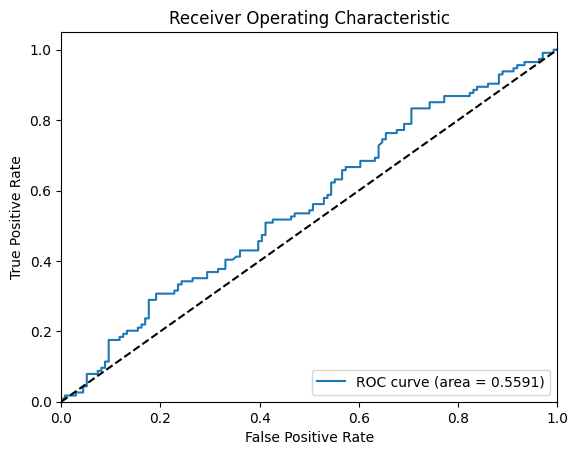

In [ ]:
# Plot ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

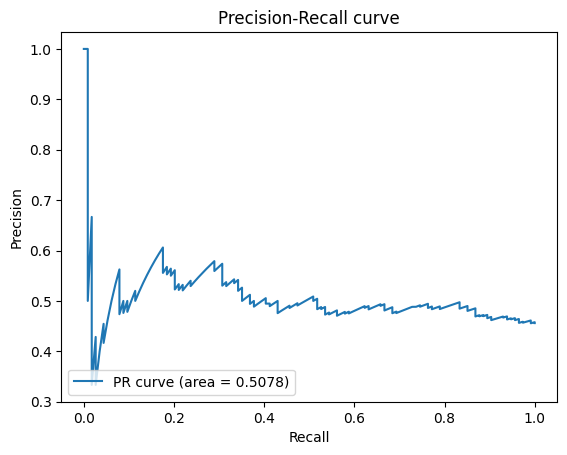

In [ ]:
# Plot PR-AUC curve
precision_array, recall_array, _ = precision_recall_curve(y_true, y_scores)
plt.figure(2)
plt.plot(recall_array, precision_array, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()